In [72]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos

In this notebook, we compare the correlations between human similarity data with the cosine distance matrices of the full BERT embeddings and the subsets of the embeddings we found were useful in WSD.

## Data Prep

In [2]:
db = access_db()
results, incl_users = get_results_elig_users(db, 'Self Consistency', 0.2)

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [42]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
lemma_counts = get_lemma_counts(results, incl_users, db)
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 10]['lemma'].tolist()
all_words = shared_words + test_repeat_words

In [47]:
matrices = {}
for w in all_words:
    matrices[w] = {}
    word, pos = w.split('_')
    cs_mtx_full, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = False, normalize = True)
    matrices[w]['bert_full'] = cs_mtx_full
    if w in test_repeat_words:
        expt_mtx = get_test_result_data(results, w, incl_users)
    else:
        expt_mtx = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_mtx
    cs_mtx_sel, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    corpus = 'select_weights', use_masc = False, normalize = True)
    matrices[w]['bert_selected'] = cs_mtx_sel

In [48]:
all_human_avg = [matrices[w]['expt'] for w in all_words]
all_bert_full = [matrices[w]['bert_full'] for w in all_words]
all_bert_sel = [matrices[w]['bert_selected'] for w in all_words]

In [75]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(all_words) & (results['userID'].isin(incl_users))]

## Global Correlations

In [68]:
pd.DataFrame(pd.Series({'nonzero_weights': mtx_correlation(all_human_avg, all_bert_sel, method = 'pearson'),
'all_weights': mtx_correlation(all_human_avg, all_bert_full, method = 'pearson')}),
             columns = ['Pearson Correlation with Average Reported Distance'])

,Pearson Correlation with Average Reported Distance
nonzero_weights,0.446852
all_weights,0.484496


## POS Correlations

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1, 'Correlation of BERT Embeddings with Experimental Data Based on PoS')

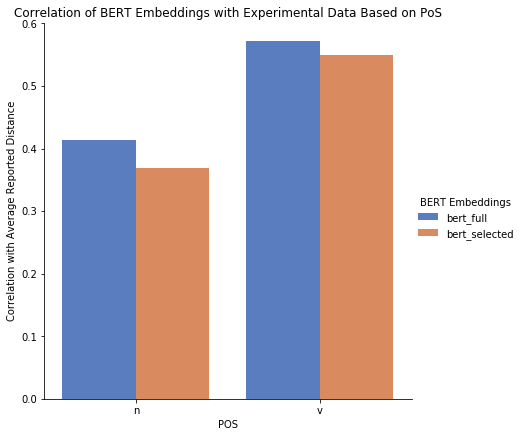

In [85]:
pos_results = []
for e in ['bert_full', 'bert_selected']:
    for p in ['n', 'v']:
        pos_results.append({"BERT Embeddings": e, "POS": p, 
                            "Correlation with Average Reported Distance": containing_query(all_trials, 'pos', [p], matrices, bert_key = e)})
pos_results = pd.DataFrame(pos_results)
sns.catplot(x="POS", y="Correlation with Average Reported Distance", hue="BERT Embeddings", data=pos_results,
                height=6, kind="bar", palette="muted")
plt.title("Correlation of BERT Embeddings with Experimental Data Based on PoS")

## Correlation with Number of Senses

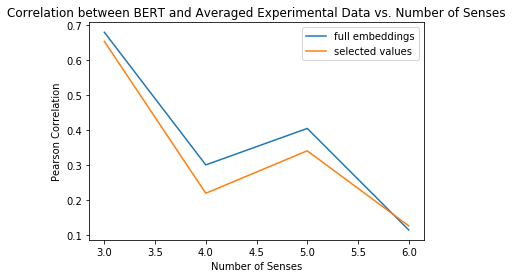

In [91]:
plt.plot(range(3, 7),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_full') for i in range(3, 7)], label = 'full embeddings')
plt.plot(range(3, 7),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_selected') for i in range(3, 7)], label = 'selected values')
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.title("Correlation between BERT and Averaged Experimental Data vs. Number of Senses")
plt.legend()

## Correlation with Entropy

In [92]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

Text(0.5, 1, 'Correlation of BERT Embeddings with Experimental Data Based on PoS')

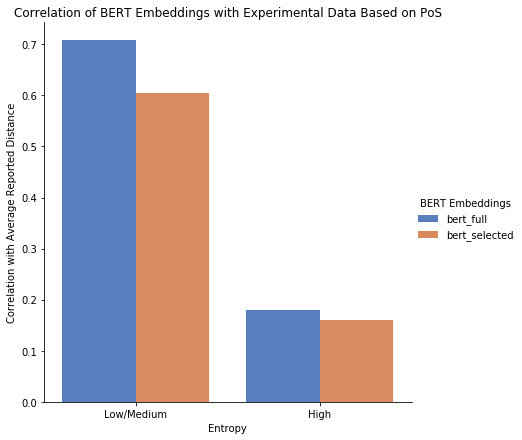

In [98]:
entropy_results = []
for e in ['bert_full', 'bert_selected']:
    for b in [(0, 1.45), (1.45, 2.5)]:
        corr_for_ent = range_query(all_entropy, 'entropy', b[0], b[1], matrices, bert_key = e)
        if b[0] == 0:
            ent_level = 'Low/Medium'
        else:
            ent_level = 'High'
        entropy_results.append({"Entropy": ent_level, 'BERT Embeddings': e,
                                    "Correlation with Average Reported Distance": corr_for_ent})
entropy_results = pd.DataFrame(entropy_results)
sns.catplot(x="Entropy", y="Correlation with Average Reported Distance", hue="BERT Embeddings", data=entropy_results,
                height=6, kind="bar", palette="muted")
plt.title("Correlation of BERT Embeddings with Experimental Data Based on PoS")